In [1]:
DATASET_NAME = 'enhanced-vulnerability-audits'

# Add root to path
import sys
current_path = sys.path[0]
root_name = 'data-lifecycle'
root_path = current_path[:sys.path[0].find(root_name) + len(root_name)]
if root_path not in sys.path:
    sys.path.insert(0, root_path)

In [2]:
from datasets import DatasetDict
from common.directories import DATASET_DIR
import matplotlib.pyplot as plt
import pandas as pd
from plotter import Plotter

plotter = Plotter(DATASET_NAME)

In [3]:
df_train = DatasetDict.load_from_disk(DATASET_DIR / DATASET_NAME)['train'].to_pandas()
df_test = DatasetDict.load_from_disk(DATASET_DIR / DATASET_NAME)['test'].to_pandas()

# concatenate train and test
df = pd.concat([df_train, df_test])

In [4]:

reentrancy_df = df[df['type'].str.contains('reentrancy', case=False, na=False)]
print(len(reentrancy_df))

arithmetic_df = df[df['type'].str.contains('arithmetic', case=False, na=False)]
print(len(arithmetic_df))

frontrunning_df = df[df['type'].str.contains('validat', case=False, na=False)]
print(len(frontrunning_df))


239
270
109


In [8]:
df_size = min(len(reentrancy_df), len(arithmetic_df), len(frontrunning_df))
combined_df = pd.concat([reentrancy_df.head(df_size), arithmetic_df.head(df_size), frontrunning_df.head(df_size)])

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
import torch

def encode_queries(queries, model, tokenizer):
    encoded_queries = []
    for query in queries:
        inputs = tokenizer(query, return_tensors='pt', padding=True, truncation=True, max_length=256)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the mean of the last hidden state as the sentence embedding
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        encoded_queries.append(embeddings)
    return np.array(encoded_queries)

def run_PCA(df, field, model, tokenizer, title, plotname, annotate=False):

    queries = df[field]

    encoded_queries = encode_queries(queries, model, tokenizer)

    # Apply PCA to reduce dimensions
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(encoded_queries)

    # Plot the clusters
    plt.figure(figsize=(10, 7))

    plt.scatter(pca_result[:df_size, 0], pca_result[:df_size, 1], c='red')
    plt.scatter(pca_result[df_size:df_size*2, 0], pca_result[df_size:df_size*2, 1], c='blue')
    plt.scatter(pca_result[df_size*2:, 0], pca_result[df_size*2:, 1], c='green')

    # Annotate points with query texts
    if annotate:
        for i, type in enumerate(combined_df['type']):
            plt.annotate(type, (pca_result[i, 0], pca_result[i, 1]))

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plotter.save_plot(plotname)

## Description

### Bert Base

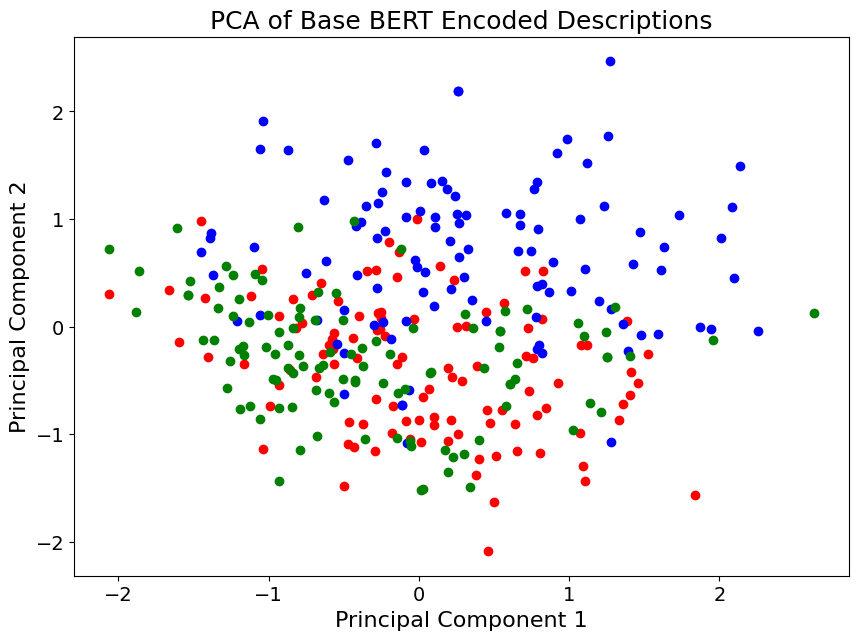

In [79]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

run_PCA(combined_df, 'description', model, tokenizer, 'PCA of Base BERT Encoded Descriptions', 'pca-descriptions-bert-base')

### Bert Large

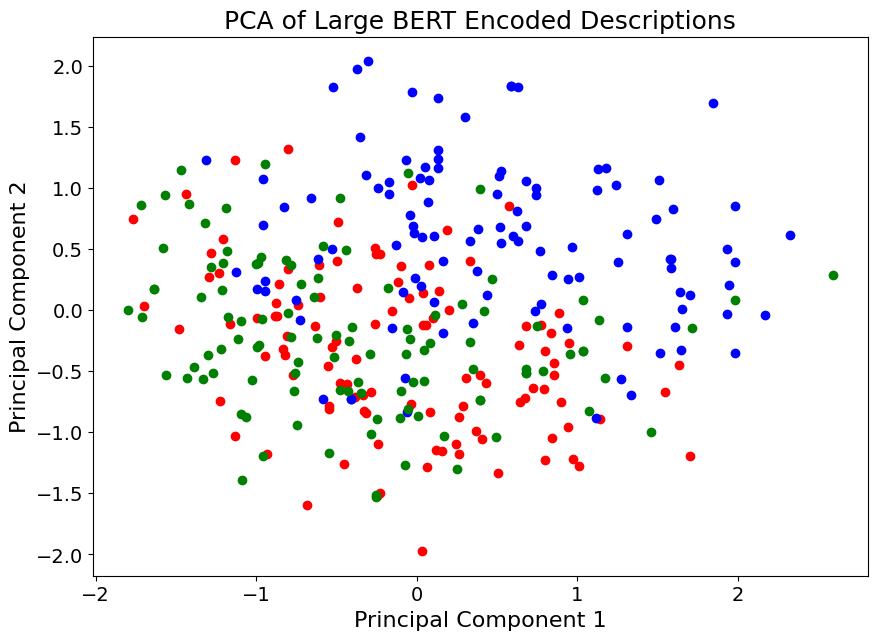

In [80]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

run_PCA(combined_df, 'description', model, tokenizer, 'PCA of Large BERT Encoded Descriptions', 'pca-descriptions-bert-large')


### Bert Base Cased

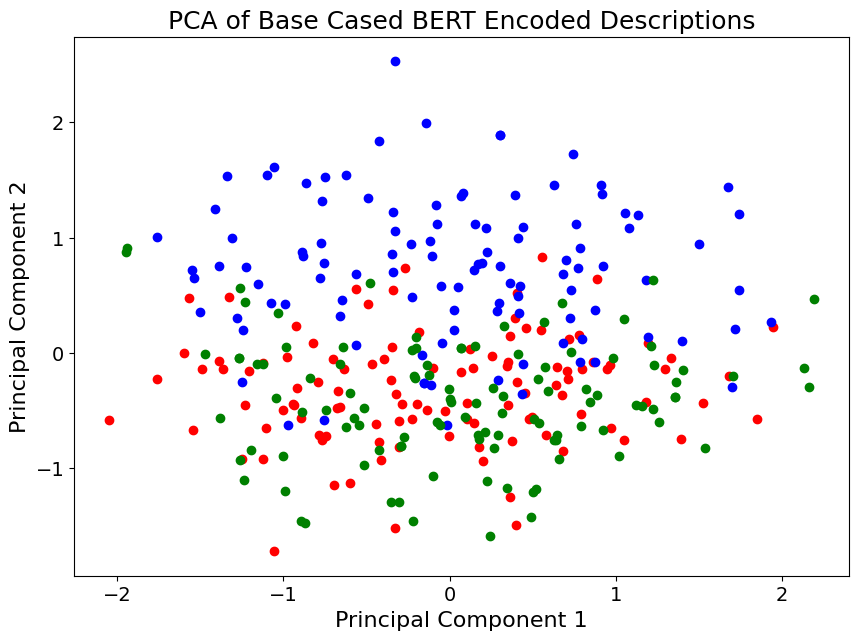

In [81]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

run_PCA(combined_df, 'description', model, tokenizer, 'PCA of Base Cased BERT Encoded Descriptions', 'pca-descriptions-bert-base-cased')


### Bert Large Cased

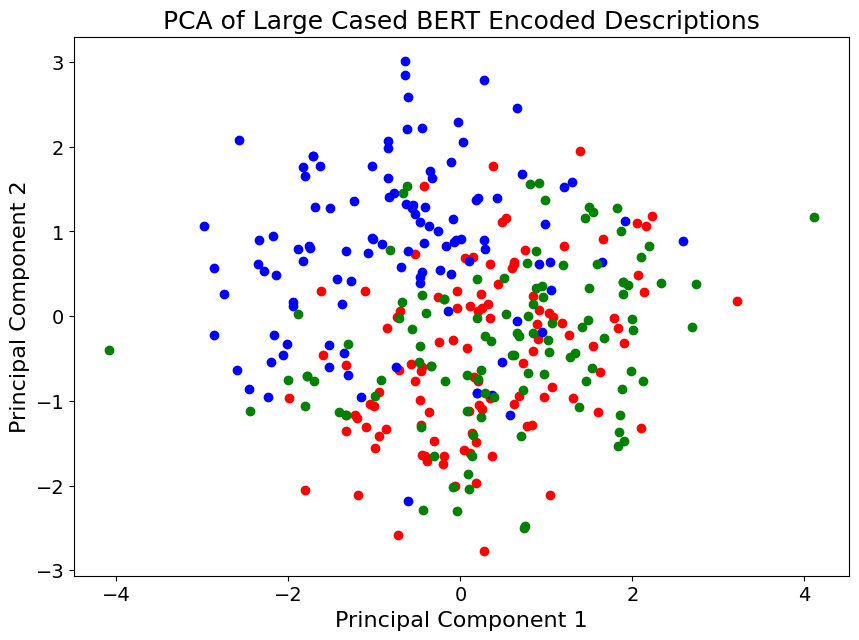

In [82]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

run_PCA(combined_df, 'description', model, tokenizer, 'PCA of Large Cased BERT Encoded Descriptions', 'pca-descriptions-bert-large-cased')


### RoBERTa

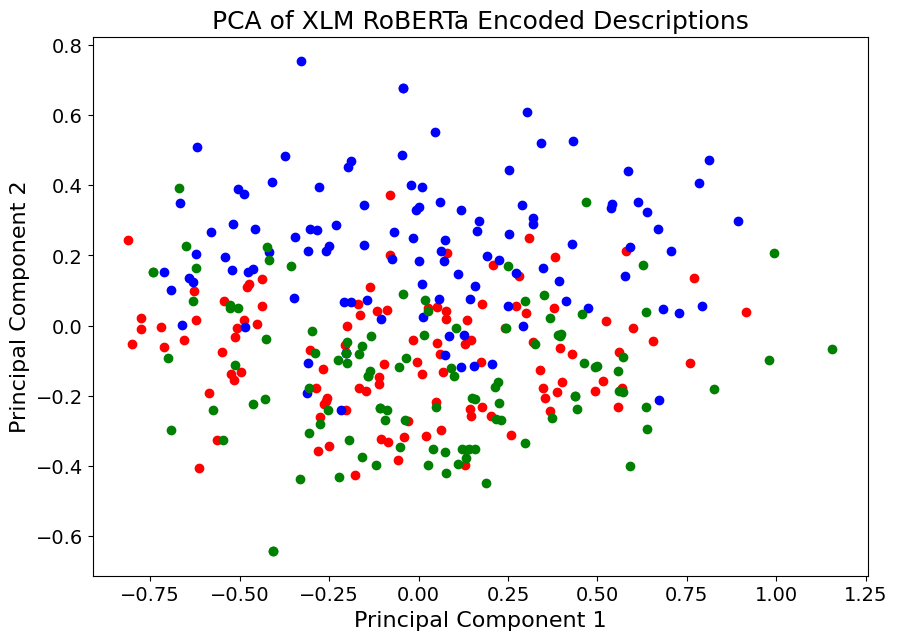

In [83]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-large')
model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-large")

run_PCA(combined_df, 'description', model, tokenizer, 'PCA of XLM RoBERTa Encoded Descriptions', 'pca-descriptions-roberta')


## Code

### Base Bert

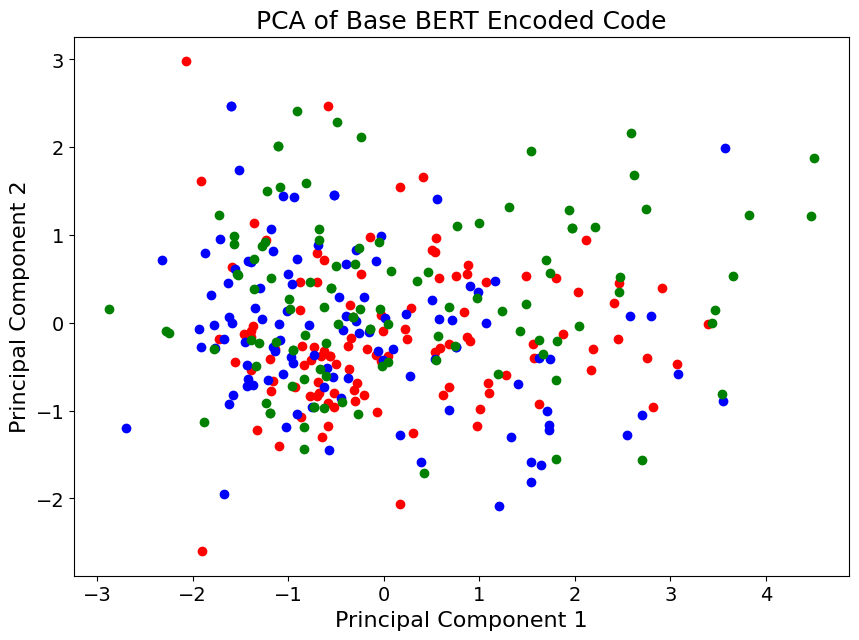

In [9]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

run_PCA(combined_df, 'code', model, tokenizer, 'PCA of Base BERT Encoded Code', 'pca-code-bert-base')

### Bert Large

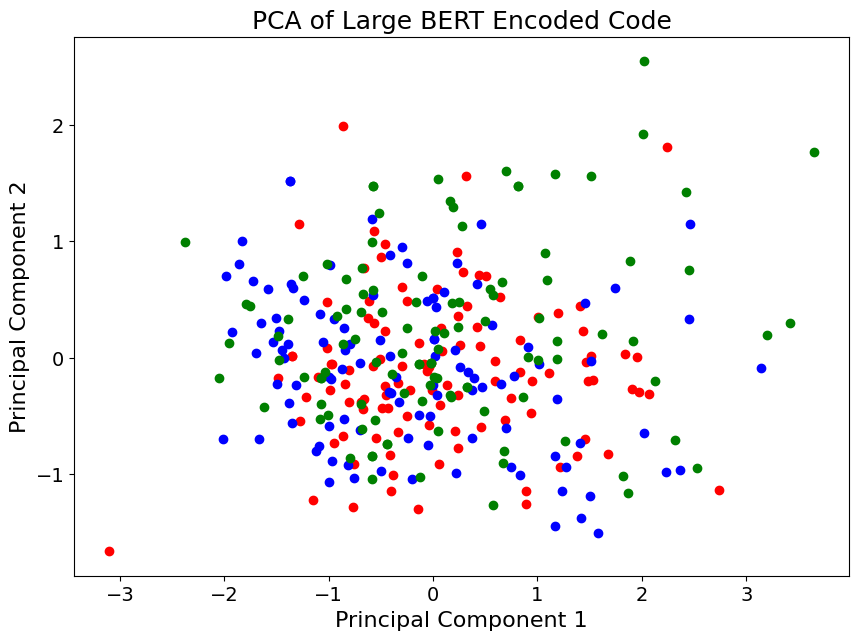

In [10]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

run_PCA(combined_df, 'code', model, tokenizer, 'PCA of Large BERT Encoded Code', 'pca-code-bert-large')

### Bert Base Cased

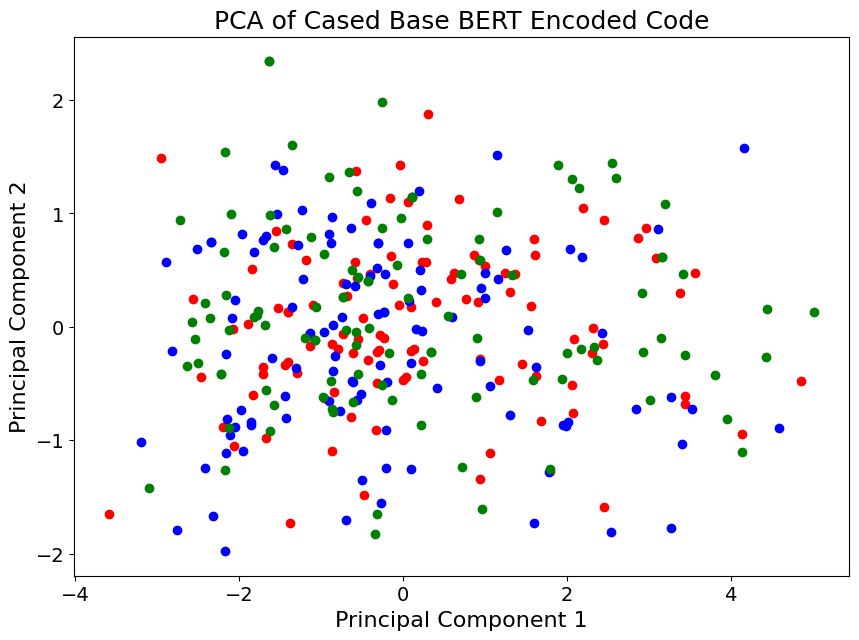

In [11]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

run_PCA(combined_df, 'code', model, tokenizer, 'PCA of Cased Base BERT Encoded Code', 'pca-code-bert-base-cased')

### Bert Large Cased

In [12]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

run_PCA(combined_df, 'code', model, tokenizer, 'PCA of Cased Large BERT Encoded Code', 'pca-code-bert-large-cased')

### RoBERTa

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-large')
model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-large")

run_PCA(combined_df, 'code', model, tokenizer, 'PCA of RoBERTa Encoded Code', 'pca-code-roberta')